In [3]:
from generate_data import wave_util
from generate_data import wave_propagation
from generate_data import postprocess_wave
from skimage.transform import resize
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (8, 6),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)
plt.rcParams['font.size'] = '14'

In [4]:
#TODO: parareal iterations

In [34]:
# set up models
import torch
from models import model_unet, model_end_to_end

#unet model setup
unet_model = model_end_to_end.restriction_nn(res_scaler=2)
# unet_model = torch.nn.DataParallel(unet_model)
unet_model.load_state_dict(torch.load('../results/run_2/saved_model_end_to_end_unet128_1.pt'))
unet_model.eval()
unet_model = unet_model.double()

unet_model2 = model_unet.UNet(depth=6, wf=1, acti_func='relu', scale_factor=2)
unet_model2 = torch.nn.DataParallel(unet_model2)
unet_model2.load_state_dict(torch.load('../results/run_1/saved_model_unet6_64_128_9.pt'))
unet_model2.eval()
unet_model2 = unet_model2.double()

netlist = [
    (r'unet 3lvl', unet_model),
    (r'unet 6lvl', unet_model2)
]

for netname,netmodl in netlist:
    model_parameters = filter(lambda p: p.requires_grad, netmodl.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print(netname,'number of trainable parameters', params)

unet 3lvl number of trainable parameters 41175
unet 6lvl number of trainable parameters 2560008


In [35]:
# parameter setup

Tf = 2.0
cT = 0.2
dx = 2.0/128.0
dt = dx / 20
ny, nx = 64, 64
m = 2
rt = 4
mt = round(Tf/cT)
t = np.linspace(0,Tf,mt)
x = np.arange(-1,1,dx)
y = np.arange(-1,1,dx)
xx,yy = np.meshgrid(x,y)

np.random.seed = 21
center = np.array([0.,0.])
# center_1 = np.array([-0.8,-0.8])
# u0_1 = np.exp(-250.0*(0.2*(xx-center_1[0])**2 + (yy-center_1[1])**2))*np.cos(8*np.pi*(yy-center_1[1]))
# center_2 = np.array([.8,.8])
# u0_2 = np.exp(-250.0*(0.2*(xx-center_2[0])**2 + (yy-center_2[1])**2))*np.cos(8*np.pi*(yy-center_2[1]))
# u0 = u0_1 + u0_2
u0 = np.exp(-250.0*(0.2*(xx-center[0])**2 + (yy-center[1])**2))*np.cos(8*np.pi*(yy-center[1]))
ut0 = np.zeros([np.size(xx,axis=1),np.size(yy,axis=0)])
vel = 1. + 0.0*yy - 0.5*(np.abs(yy+xx-0.)>0.4) + 0.*(np.abs(xx-0.4)<0.2)*(np.abs(yy-0.5)<0.1) #np.ones([np.size(xx,axis=1),np.size(yy,axis=0)]) #fig9 vel

# def four_layers(x, y):
#     res = x + np.pi / 3.1 * y
#     if res < -1:
#         return .2
#     elif res < 0:
#         return .6
#     elif res < 1:
#         return .8
#     else:
#         return 1
#
# # four layers velocity
# dim = 128
# v_x = np.linspace(-1, 1, num=dim)
# v_y = np.linspace(-1, 1, num=dim)
# z = np.array([four_layers(i, j) for j in v_y for i in v_x])
# Z = np.array(z).reshape(dim, dim)
# vel = Z

veltest = (
   ('refrac',vel),
)

In [36]:
for velname, vel in veltest:

    #### Fine solution ####
    uf = np.zeros([xx.shape[0],xx.shape[1],mt])
    utf = np.zeros([xx.shape[0],xx.shape[1],mt])
    uf[:,:,0] = u0
    utf[:,:,0] = ut0
    for j in range(1,mt):
        uf[:,:,j],utf[:,:,j] = wave_propagation.velocity_verlet(uf[:,:,j-1],utf[:,:,j-1],vel,dx,dt,cT)

    #### Coarse solution ####
    ucc = np.zeros([xx.shape[0],xx.shape[1],mt])
    utcc = np.zeros([xx.shape[0],xx.shape[1],mt])
    ucc[:,:,0] = u0
    utcc[:,:,0] = ut0
    uc = resize(ucc[:,:,0],[ny,nx],order=4)
    utc = resize(utcc[:,:,0],[ny,nx],order=4)
    velc = resize(vel,[ny,nx],order=4)
    
    for j in range(1,mt):
        uc, utc = wave_propagation.velocity_verlet(uc,utc,velc,dx*m,dt*rt,cT)
        ucc[:,:,j] = resize(uc,[xx.shape[0],xx.shape[1]],order=4)
        utcc[:,:,j] = resize(utc,[xx.shape[0],xx.shape[1]],order=4)

    #### End-to-end solution ####
    unn1 = np.zeros([mt, xx.shape[0],xx.shape[1]])
    utnn1 = np.zeros([mt, xx.shape[0],xx.shape[1]])
    unn1[0,:,:] = u0
    utnn1[0,:,:] = ut0
    u02 = torch.from_numpy(u0)
    ut02 = torch.from_numpy(ut0)
    vel2 = torch.from_numpy(vel)

    with torch.no_grad():
        for j in range(1,mt):
            input_tensor = torch.cat([u02.unsqueeze(dim=0),ut02.unsqueeze(dim=0),vel2.unsqueeze(dim=0)], dim=0).unsqueeze(dim=0)
            res = unet_model(input_tensor)
            unn1[j,:,:],utnn1[j,:,:] = res[:,0,:,:], res[:,1,:,:]
            u02, ut02 = torch.from_numpy(unn1[j,:,:]), torch.from_numpy(utnn1[j,:,:])

        #print(input_tensor.shape)
        #print(unet_model(input_tensor)) # b x 3 x w x h
        # uc,utc = wave_propagation.velocity_verlet(resize(unn1[:,:,j-1],[ny,nx],order=4),
        #                      resize(utnn1[:,:,j-1],[ny,nx],order=4),
        #                      resize(vel,[ny,nx],order=4),dx*m,dt*rt,cT)
        # unn1[:,:,j],utnn1[:,:,j] = postprocess_wave.ApplyJNet2WaveSol(uc,utc,vel,dx,unet_model,m)

    #### UNet6 solution ####
    unn2 = np.zeros([xx.shape[0],xx.shape[1],mt])
    utnn2 = np.zeros([xx.shape[0],xx.shape[1],mt])
    unn2[:,:,0] = u0
    utnn2[:,:,0] = ut0
    for j in range(1,mt):
        uc,utc = wave_propagation.velocity_verlet(resize(unn2[:,:,j-1],[ny,nx],order=4),
                             resize(utnn2[:,:,j-1],[ny,nx],order=4),
                             resize(vel,[ny,nx],order=4),dx*m,dt*rt,cT)
        unn2[:,:,j],utnn2[:,:,j] = postprocess_wave.ApplyJNet2WaveSol(uc,utc,vel,dx,unet_model2,m)

In [40]:
unn1.shape

(10, 128, 128)

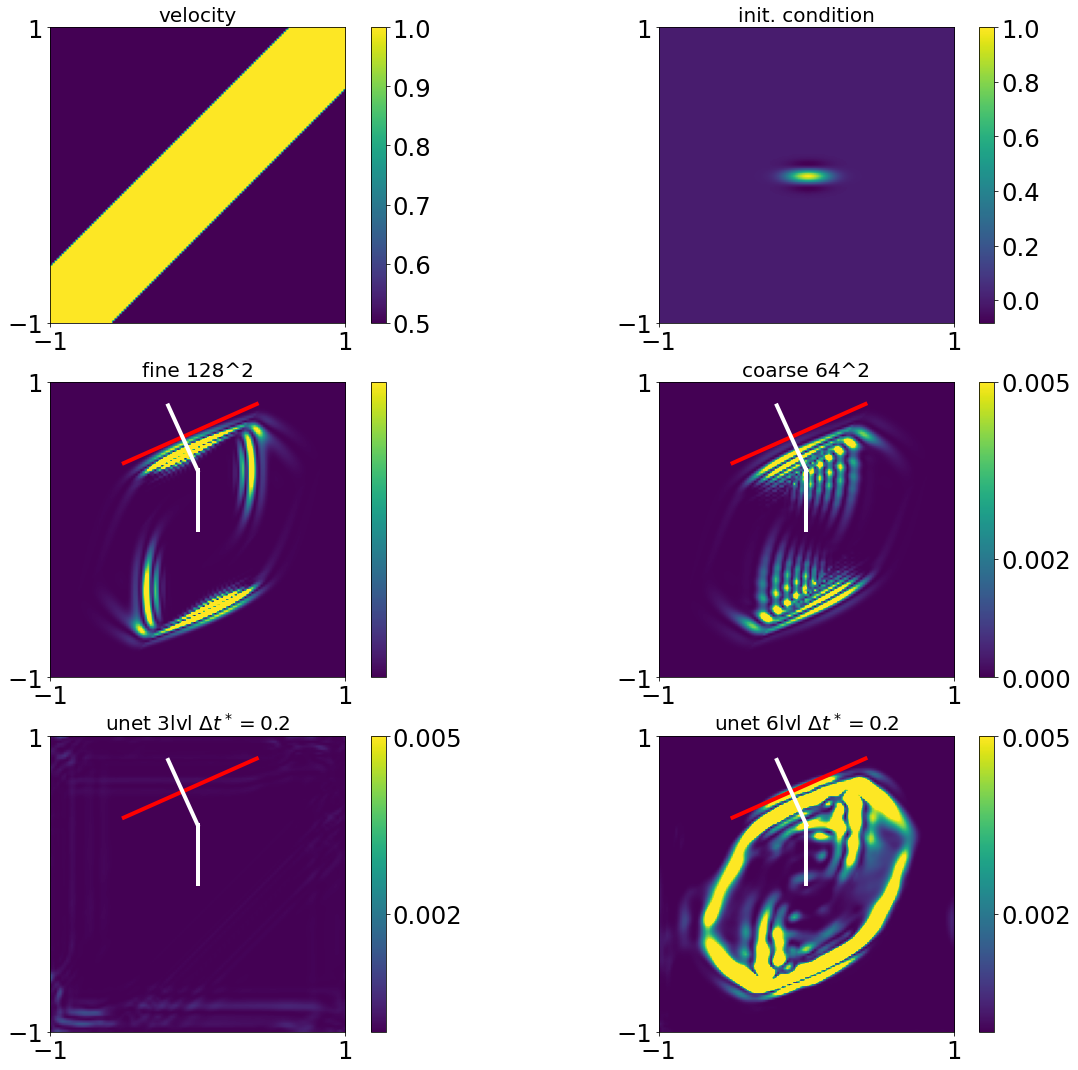

In [45]:
tj = 4
fig1 = plt.figure(figsize=(20,25))
scaler = 50

ax1 = fig1.add_subplot(4,2,1)
pos1 = ax1.imshow(vel,extent=(-1,1,-1,1))
ax1.set_title('velocity', fontsize=20)
plt.xticks([-1,1])
plt.yticks([-1,1])
plt.colorbar(pos1)

ax2 = fig1.add_subplot(4,2,2)
pos2 = ax2.imshow(u0,extent=(-1,1,-1,1))
ax2.set_title('init. condition', fontsize=20)
plt.xticks([-1,1])
plt.yticks([-1,1])
plt.colorbar(pos2)

ax3 = fig1.add_subplot(4,2,3)
pos3 = ax3.imshow(wave_util.WaveEnergyField(uf[:,:,tj],utf[:,:,tj],vel,dx)*dx*dx,vmax=0.005,extent=(-1,1,-1,1))
ax3.set_title('fine 128^2', fontsize=20)
plt.xticks([-1,1])
plt.yticks([-1,1])
plt.plot([-0.5,0.4],[0.45,0.85],'r',linewidth=4)
plt.plot([0.,0.],[0.,0.4],'w',linewidth=4)
plt.plot([0.,-0.2],[0.4,0.84],'w',linewidth=4)
plt.colorbar(pos1,ticks = [0,0.002,0.005])

ax4 = fig1.add_subplot(4,2,4)
pos4 = ax4.imshow(wave_util.WaveEnergyField(ucc[:,:,tj],utcc[:,:,tj],vel,dx)*dx*dx,vmax=.005,extent=(-1,1,-1,1))
ax4.set_title('coarse 64^2', fontsize=20)
plt.xticks([-1,1])
plt.yticks([-1,1])
plt.plot([-0.5,0.4],[0.45,0.85],'r',linewidth=4)
plt.plot([0.,0.],[0.,0.4],'w',linewidth=4)
plt.plot([0.,-0.2],[0.4,0.84],'w',linewidth=4)
plt.colorbar(pos4,ticks = [0,0.002,0.005])

ax5 = fig1.add_subplot(4,2,5)
pos5 = ax5.imshow(wave_util.WaveEnergyField(unn1[tj,:,:],utnn1[tj,:,:],vel,dx)*dx*dx*scaler,vmax=.005,extent=(-1,1,-1,1))
ax5.set_title(r'unet 3lvl $\Delta t^*=0.2$', fontsize=20)
plt.xticks([-1,1])
plt.yticks([-1,1])
plt.plot([-0.5,0.4],[0.45,0.85],'r',linewidth=4)
plt.plot([0.,0.],[0.,0.4],'w',linewidth=4)
plt.plot([0.,-0.2],[0.4,0.84],'w',linewidth=4)
plt.colorbar(pos5,ticks = [0,0.002,0.005])

ax6 = fig1.add_subplot(4,2,6)
pos6 = ax6.imshow(wave_util.WaveEnergyField(unn2[:,:,tj],utnn2[:,:,tj],vel,dx)*dx*dx*scaler,vmax=0.005,extent=(-1,1,-1,1))
ax6.set_title(r'unet 6lvl $\Delta t^*=0.2$', fontsize=20)
plt.xticks([-1,1])
plt.yticks([-1,1])
plt.plot([-0.5,0.4],[0.45,0.85],'r',linewidth=4)
plt.plot([0.,0.],[0.,0.4],'w',linewidth=4)
plt.plot([0.,-0.2],[0.4,0.84],'w',linewidth=4)
plt.colorbar(pos6, ticks = [0,0.002,0.005])

In [38]:
unn1[1,:,:]

array([[0.00693426, 0.00746265, 0.00853589, ..., 0.00332675, 0.00360316,
        0.00538721],
       [0.00626981, 0.00567829, 0.00592075, ..., 0.00369189, 0.00374947,
        0.00526565],
       [0.00565081, 0.00558178, 0.00507974, ..., 0.00427044, 0.00422558,
        0.00442256],
       ...,
       [0.00313187, 0.0022066 , 0.0019781 , ..., 0.00677167, 0.00622861,
        0.00462714],
       [0.00382895, 0.00380594, 0.00374237, ..., 0.0073758 , 0.00676048,
        0.00469823],
       [0.00559822, 0.00716824, 0.00801149, ..., 0.00500121, 0.00514171,
        0.00469505]])

In [41]:
# compare wave energy norm errors:

from sklearn.metrics import mean_squared_error, mean_absolute_error
from tabulate import tabulate

table = [["snapshot", "MSE unet3", "MSE unet6", "MSE tiramisu", "MSE u_transform"]]
# table = [["snapshot", "MAE unet3", "MAE unet6", "MAE tiramisu", "MAE u_transform"]]

for it in range(1,10):
    wf = wave_util.WaveEnergyField(uf[:,:,it], utf[:,:,it], vel, dx)*dx*dx
    w1 = wave_util.WaveEnergyField(unn1[it,:,:], utnn1[it,:,:], vel, dx)*dx*dx
    w2 = wave_util.WaveEnergyField(unn2[:,:,it], utnn2[:,:,it], vel, dx)*dx*dx

    # mae1 = mean_absolute_error(wf, w1)
    # mae2 = mean_absolute_error(wf, w2)
    # mae3 = mean_absolute_error(wf, w3)
    # mae4 = mean_absolute_error(wf, w4)

    mse1 = mean_squared_error(wf, w1)
    mse2 = mean_squared_error(wf, w2)

    table.append([it, mse1, mse2])
    #table.append([it, mae1, mae2, mae3, mae4])

print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

╒════════════╤═════════════╤═════════════╕
│   snapshot │   MSE unet3 │   MSE unet6 │
╞════════════╪═════════════╪═════════════╡
│          1 │ 1.14206e-05 │ 6.38465e-06 │
├────────────┼─────────────┼─────────────┤
│          2 │ 9.48823e-06 │ 6.68014e-06 │
├────────────┼─────────────┼─────────────┤
│          3 │ 5.80078e-06 │ 4.96337e-06 │
├────────────┼─────────────┼─────────────┤
│          4 │ 4.15222e-06 │ 3.74644e-06 │
├────────────┼─────────────┼─────────────┤
│          5 │ 3.21857e-06 │ 2.93885e-06 │
├────────────┼─────────────┼─────────────┤
│          6 │ 2.58684e-06 │ 2.38362e-06 │
├────────────┼─────────────┼─────────────┤
│          7 │ 2.12428e-06 │ 1.96558e-06 │
├────────────┼─────────────┼─────────────┤
│          8 │ 1.9598e-06  │ 1.78991e-06 │
├────────────┼─────────────┼─────────────┤
│          9 │ 1.58177e-06 │ 1.43194e-06 │
╘════════════╧═════════════╧═════════════╛
